In [ ]:
!nvidia-smi

Wed May 24 19:49:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.auto import tqdm
import torchvision.models as models
import torch.nn as nn
import torch
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from collections import Counter
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from transformers import ViTModel, ViTForImageClassification, ViTConfig
from torch.optim.lr_scheduler import StepLR

In [ ]:
def get_prediction(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            # Append predicted labels and true labels to the lists
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

            idxs_mask = ((preds == labels) == False).nonzero()
            if idxs_mask.numel():
              incorrect_examples.extend(images[idxs_mask].cpu().numpy())
              incorrect_labels.extend(labels[idxs_mask].cpu().numpy()) #the corresponding target to the misclassified image
              incorrect_pred.extend(preds[idxs_mask].cpu().numpy()) #the corresponiding predicted class of the misclassified image

def get_prediction2(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.logits.data, 1)
            # Append predicted labels and true labels to the lists
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

            idxs_mask = ((preds == labels) == False).nonzero()
            if idxs_mask.numel():
              incorrect_examples.extend(images[idxs_mask].cpu().numpy())
              incorrect_labels.extend(labels[idxs_mask].cpu().numpy()) #the corresponding target to the misclassified image
              incorrect_pred.extend(preds[idxs_mask].cpu().numpy()) #the corresponiding predicted class of the misclassified image

In [ ]:
# Training transforms
def get_train_transform(IMAGE_SIZE, pretrained):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return train_transform
# Validation transforms
def get_valid_transform(IMAGE_SIZE, pretrained):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return valid_transform
# Image normalization transforms.
def normalize_transform(pretrained):
    if pretrained: # Normalization for pre-trained weights.
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    else: # Normalization when training from scratch.
        normalize = transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    return normalize

In [ ]:
def get_datasets(pretrained):
    """
    Function to prepare the Datasets.
    :param pretrained: Boolean, True or False.
    Returns the training and validation datasets along 
    with the class names.
    """
    dataset = datasets.ImageFolder(
        ROOT_DIR, 
        transform=(get_train_transform(IMAGE_SIZE, pretrained))
    )
    valid_size = int(len(dataset) * VALID_SPLIT)
    train_size = len(dataset) - valid_size
    dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [train_size, valid_size])
    dataset_size = len(dataset)
    return dataset, dataset_train, dataset_valid, dataset.classes

def get_data_loaders(dataset_train, dataset_valid):
    """
    Prepares the training and validation data loaders.
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=NUM_WORKERS
    )
    return train_loader, valid_loader

In [ ]:
#  Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# Validation function.
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# Required constants.
ROOT_DIR = '/content/drive/MyDrive/FYPImages/datasets'
VALID_SPLIT = 0.3
IMAGE_SIZE = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 32 
NUM_WORKERS = 4 # Number of parallel processes for data preparation
pretrained = True

In [ ]:
# Load the training and validation datasets.
dataset, dataset_train, dataset_valid, dataset_classes = get_datasets(pretrained)
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Class names: {dataset_classes}\n")
# Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)
num_classes = len(dataset_classes)

[INFO]: Number of training images: 793
[INFO]: Number of validation images: 339
[INFO]: Class names: ['Digging', 'Eating', 'Flopping_Loafing', 'Jumping_Binky', 'Laying', 'Mating_Humping', 'Periscope']



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


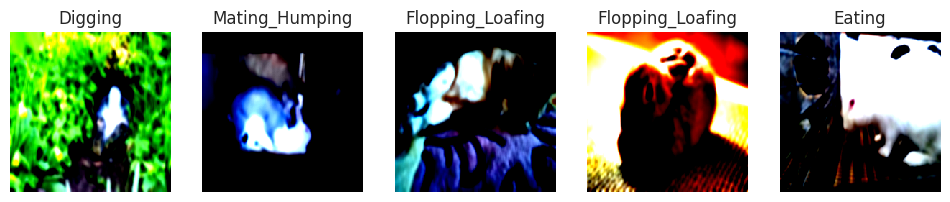

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select 5 random images from the training dataset
num_images = 5
random_indices = random.sample(range(len(dataset_train)), num_images)

# Plot the selected images
fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(12, 4))
for i, idx in enumerate(random_indices):
    img, label = dataset_train[idx]
    axs[i].imshow(img.permute(1, 2, 0), interpolation='none')
    axs[i].axis('off')
    axs[i].set_title(dataset_classes[label])
plt.show()



{'Digging': 156, 'Eating': 188, 'Flopping_Loafing': 117, 'Jumping_Binky': 229, 'Laying': 233, 'Mating_Humping': 107, 'Periscope': 102}


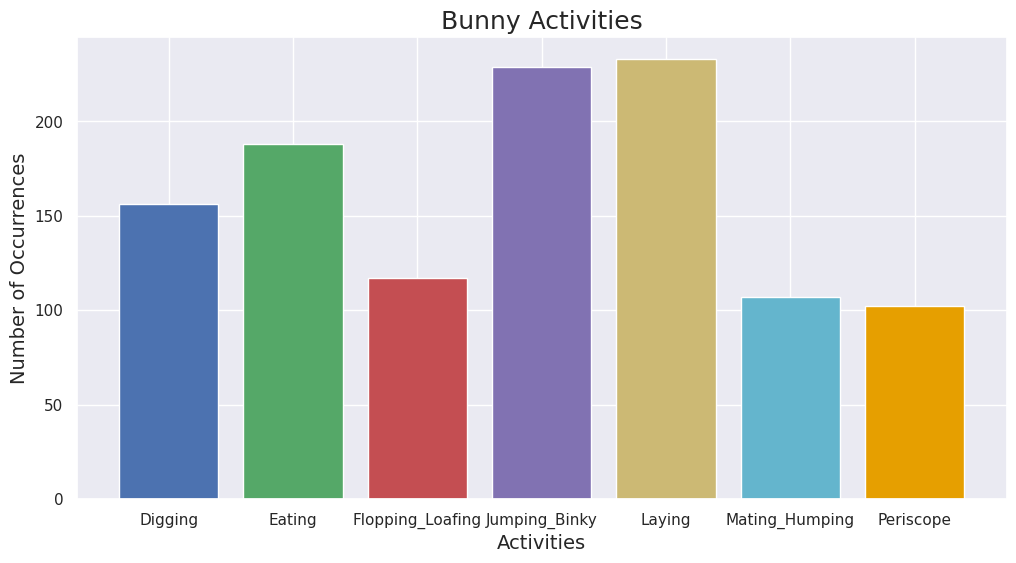

In [ ]:
idx_to_class = {v:k for k, v in dataset.class_to_idx.items()}  # Index to class mapping
idx_distribution = dict(Counter(dataset.targets))
class_distribution = {idx_to_class[k]:v for k, v in idx_distribution.items()}

print(class_distribution)
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ccb974', '#64b5cd', '#e69f00']
for i, (activity, occurrences) in enumerate(class_distribution.items()):
    ax.bar(activity, occurrences, color=colors[i % len(colors)])
ax.set_xlabel("Activities", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Bunny Activities", fontsize=18)
plt.show()

**Finetune Using ResNet18**

In [ ]:
def build_model(pretrained=True, fine_tune=True, num_classes=2):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.resnet18(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.fc = nn.Sequential(
        nn.Linear(in_features=512, out_features=256),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=256, out_features=num_classes)
    )
    return model

In [ ]:
use_cuda = torch.cuda.is_available()
device =  torch.device('cuda' if use_cuda else 'cpu')
model = build_model(
    pretrained=pretrained, 
    fine_tune=True, 
    num_classes=len(dataset_classes)
).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...
11,309,639 total parameters.
11,309,639 training parameters.


In [ ]:
lr = 0.0001
epochs = 20

In [ ]:
# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

In [ ]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
   

[INFO]: Epoch 1 of 20
Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 1.743, training acc: 33.670
Validation loss: 1.392, validation acc: 61.947
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 1.172, training acc: 66.583
Validation loss: 0.996, validation acc: 70.796
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.783, training acc: 78.058
Validation loss: 0.802, validation acc: 77.876
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.489, training acc: 88.525
Validation loss: 0.701, validation acc: 78.466
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.318, training acc: 92.938
Validation loss: 0.647, validation acc: 78.171
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.190, training acc: 96.217
Validation loss: 0.665, validation acc: 77.286
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.127, training acc: 97.352
Validation loss: 0.714, validation acc: 77.286
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.079, training acc: 99.117
Validation loss: 0.668, validation acc: 78.466
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.050, training acc: 99.117
Validation loss: 0.737, validation acc: 76.991
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.044, training acc: 99.622
Validation loss: 0.730, validation acc: 76.401
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.033, training acc: 99.748
Validation loss: 0.808, validation acc: 74.631
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.026, training acc: 99.622
Validation loss: 0.758, validation acc: 76.696
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.027, training acc: 99.622
Validation loss: 0.714, validation acc: 78.466
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.025, training acc: 99.496
Validation loss: 0.785, validation acc: 76.106
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.022, training acc: 99.369
Validation loss: 0.783, validation acc: 75.516
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.019, training acc: 99.748
Validation loss: 0.744, validation acc: 75.811
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.031, training acc: 99.369
Validation loss: 0.754, validation acc: 77.581
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.016, training acc: 99.874
Validation loss: 0.803, validation acc: 76.991
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.014, training acc: 99.748
Validation loss: 0.817, validation acc: 77.286
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.013, training acc: 99.622
Validation loss: 0.750, validation acc: 76.696
--------------------------------------------------


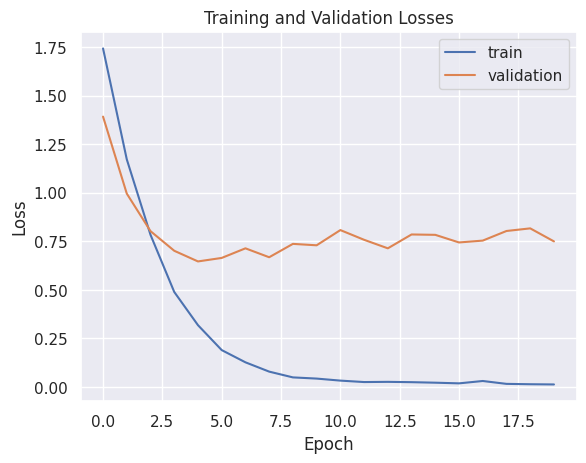

In [ ]:
import matplotlib.pyplot as plt

# Plot the train and validation losses
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


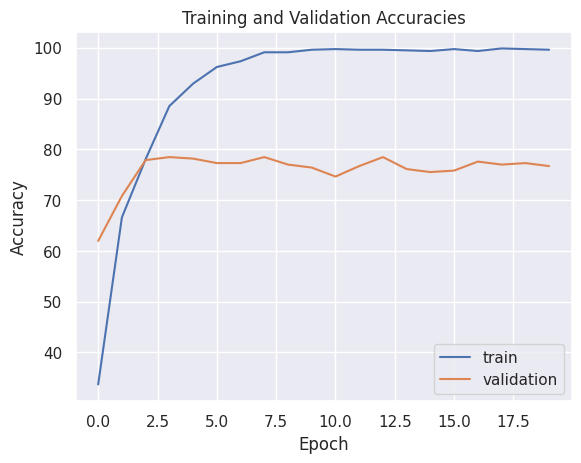

In [ ]:
# Plot the train and validation accuracies
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
all_preds = []
all_labels = []
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []

get_prediction(model, valid_loader, device)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


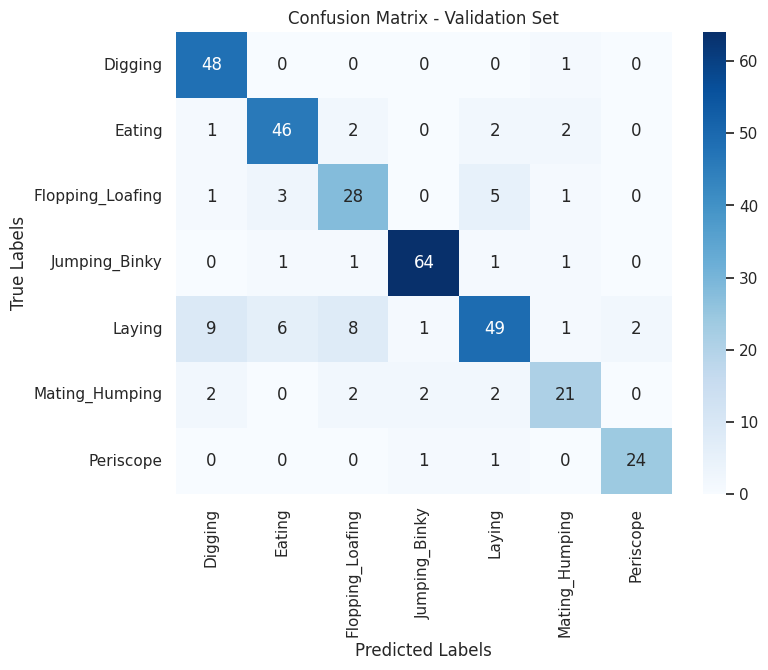

In [ ]:
# Plot the confusion matrix using seaborn
cm = confusion_matrix(all_preds, all_labels)
sns.set()
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".0f", xticklabels=dataset_classes, yticklabels=dataset_classes)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
print(classification_report(all_labels, all_preds, target_names=dataset_classes))

                  precision    recall  f1-score   support

         Digging       0.77      0.82      0.80        50
          Eating       0.82      0.84      0.83        61
Flopping_Loafing       0.76      0.78      0.77        40
   Jumping_Binky       0.90      0.84      0.87        67
          Laying       0.69      0.61      0.65        77
  Mating_Humping       0.62      0.62      0.62        26
       Periscope       0.56      0.83      0.67        18

        accuracy                           0.76       339
       macro avg       0.73      0.76      0.74       339
    weighted avg       0.76      0.76      0.76       339



**Finetune Using EfficientNet**

In [ ]:
def build_model(pretrained=True, fine_tune=True, num_classes=2):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b4(pretrained=True)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier[1] = nn.Sequential(
        nn.Linear(in_features=1792, out_features=512),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(in_features=512, out_features=num_classes)
    )
    return model

In [ ]:
model = build_model(
    pretrained=pretrained, 
    fine_tune=True, 
    num_classes=len(dataset_classes)
).to(device)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)

[INFO]: Loading pre-trained weights


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:02<00:00, 38.3MB/s]


[INFO]: Fine-tuning all layers...
18,470,223 total parameters.
18,470,223 training parameters.


In [ ]:
epochs = 20

In [ ]:
# Loss function.
criterion = nn.CrossEntropyLoss()
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
   

[INFO]: Epoch 1 of 20
Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 1.930, training acc: 22.068
Validation loss: 1.901, validation acc: 39.823
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 1.858, training acc: 36.696
Validation loss: 1.815, validation acc: 39.528
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 1.744, training acc: 37.201
Validation loss: 1.667, validation acc: 42.478
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 1.546, training acc: 45.649
Validation loss: 1.435, validation acc: 54.277
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 1.258, training acc: 58.134
Validation loss: 1.187, validation acc: 64.897
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 1.009, training acc: 68.222
Validation loss: 0.983, validation acc: 66.077
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.777, training acc: 75.914
Validation loss: 0.809, validation acc: 72.861
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.633, training acc: 78.815
Validation loss: 0.742, validation acc: 73.156
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.567, training acc: 79.571
Validation loss: 0.652, validation acc: 74.631
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.450, training acc: 85.372
Validation loss: 0.665, validation acc: 76.401
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.376, training acc: 86.003
Validation loss: 0.714, validation acc: 73.746
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.332, training acc: 89.281
Validation loss: 0.610, validation acc: 80.531
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.244, training acc: 91.929
Validation loss: 0.612, validation acc: 79.941
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.219, training acc: 93.064
Validation loss: 0.678, validation acc: 75.811
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.189, training acc: 94.451
Validation loss: 0.627, validation acc: 79.351
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.192, training acc: 93.190
Validation loss: 0.673, validation acc: 78.466
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.163, training acc: 95.082
Validation loss: 0.614, validation acc: 81.711
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.146, training acc: 94.830
Validation loss: 0.671, validation acc: 78.171
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.113, training acc: 96.091
Validation loss: 0.648, validation acc: 79.056
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


  0%|          | 0/25 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 0.104, training acc: 96.343
Validation loss: 0.652, validation acc: 80.531
--------------------------------------------------


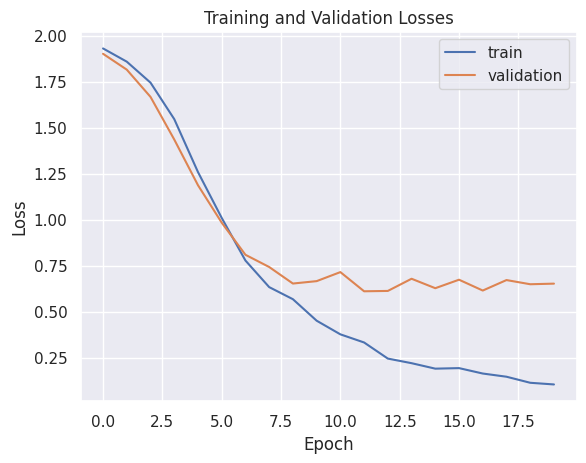

In [ ]:
# Plot the train and validation losses
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


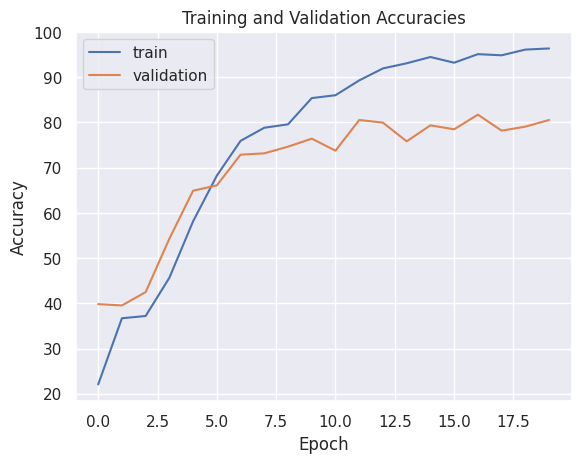

In [ ]:
# Plot the train and validation accuracies
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
all_preds = []
all_labels = []
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []
get_prediction(model, valid_loader, device)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


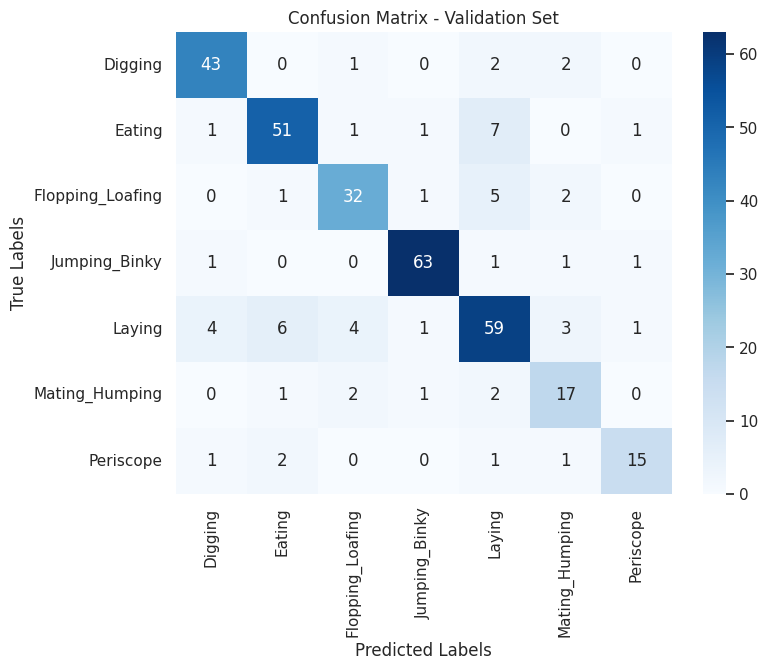

In [ ]:
# Plot the confusion matrix using seaborn
cm = confusion_matrix(all_preds, all_labels)
sns.set()
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".0f", xticklabels=dataset_classes, yticklabels=dataset_classes)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
print(classification_report(all_labels, all_preds, target_names=dataset_classes))

                  precision    recall  f1-score   support

         Digging       0.90      0.86      0.88        50
          Eating       0.82      0.84      0.83        61
Flopping_Loafing       0.78      0.80      0.79        40
   Jumping_Binky       0.94      0.94      0.94        67
          Laying       0.76      0.77      0.76        77
  Mating_Humping       0.74      0.65      0.69        26
       Periscope       0.75      0.83      0.79        18

        accuracy                           0.83       339
       macro avg       0.81      0.81      0.81       339
    weighted avg       0.83      0.83      0.83       339



**Finetuning the Datset on Vision In Transformer**

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
use_cuda, device

(True, device(type='cuda'))

In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.classifier = nn.Linear(in_features=768, out_features=num_classes, bias=True)
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

85,804,039 total parameters.
85,804,039 training parameters.


In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
def train_model(model, train_dataloader, val_dataloader, learning_rate, epochs):   
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0

            for i, (train_images, train_labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)): #tqdm(train_dataloader):                
                train_images = train_images.to(device)
                train_labels = train_labels.to(device)

                optimizer.zero_grad()

                output = model(train_images)
                criterion
                batch_loss = criterion(output.logits, train_labels.long())
                total_loss_train += batch_loss.item()
            
                _, predicted = torch.max(output.logits.data, 1)
                acc = (predicted == train_labels).sum().item()
                total_acc_train += acc

                batch_loss.backward()
                optimizer.step()
                
            scheduler.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():
                for i, (val_images, val_labels) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)): #val_dataloader:
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    output = model(val_images)

                    batch_loss = criterion(output.logits, val_labels.long())
                    total_loss_val += batch_loss.item()
                    
                    _, predicted = torch.max(output.logits.data, 1)
                    acc = (predicted == val_labels).sum().item()
                    total_acc_val += acc
            
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataloader.dataset): .3f}, Train Accuracy: {total_acc_train / len(train_dataloader.dataset): .3f}, Val Loss: {total_loss_val / len(val_dataloader.dataset): .3f}, Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
            
            train_losses.append(total_loss_train / len(train_dataloader.dataset))
            train_accs.append(total_acc_train / len(train_dataloader.dataset))
            val_losses.append(total_loss_val / len(val_dataloader.dataset))
            val_accs.append(total_acc_val / len(val_dataloader.dataset))

In [ ]:
lr = 1e-4
num_epochs=20
train_model(model, train_loader, valid_loader, lr, num_epochs)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 1 | Train Loss:  0.016, Train Accuracy:  0.845, Val Loss:  0.018, Val Accuracy:  0.841


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 2 | Train Loss:  0.004, Train Accuracy:  0.980, Val Loss:  0.016, Val Accuracy:  0.841


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 3 | Train Loss:  0.001, Train Accuracy:  0.991, Val Loss:  0.015, Val Accuracy:  0.855


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 4 | Train Loss:  0.001, Train Accuracy:  0.999, Val Loss:  0.016, Val Accuracy:  0.829


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 5 | Train Loss:  0.001, Train Accuracy:  0.997, Val Loss:  0.015, Val Accuracy:  0.835


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 6 | Train Loss:  0.000, Train Accuracy:  0.999, Val Loss:  0.016, Val Accuracy:  0.844


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 7 | Train Loss:  0.000, Train Accuracy:  0.999, Val Loss:  0.016, Val Accuracy:  0.850


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 8 | Train Loss:  0.000, Train Accuracy:  0.997, Val Loss:  0.016, Val Accuracy:  0.841


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 9 | Train Loss:  0.000, Train Accuracy:  0.999, Val Loss:  0.016, Val Accuracy:  0.847


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 10 | Train Loss:  0.000, Train Accuracy:  0.999, Val Loss:  0.017, Val Accuracy:  0.844


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 11 | Train Loss:  0.000, Train Accuracy:  0.997, Val Loss:  0.016, Val Accuracy:  0.841


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 12 | Train Loss:  0.000, Train Accuracy:  0.997, Val Loss:  0.017, Val Accuracy:  0.841


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 13 | Train Loss:  0.000, Train Accuracy:  0.997, Val Loss:  0.017, Val Accuracy:  0.832


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 14 | Train Loss:  0.000, Train Accuracy:  0.999, Val Loss:  0.016, Val Accuracy:  0.835


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 15 | Train Loss:  0.000, Train Accuracy:  0.999, Val Loss:  0.017, Val Accuracy:  0.841


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 16 | Train Loss:  0.000, Train Accuracy:  0.999, Val Loss:  0.017, Val Accuracy:  0.853


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 17 | Train Loss:  0.000, Train Accuracy:  0.999, Val Loss:  0.017, Val Accuracy:  0.832


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 18 | Train Loss:  0.000, Train Accuracy:  0.997, Val Loss:  0.017, Val Accuracy:  0.829


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 19 | Train Loss:  0.000, Train Accuracy:  0.997, Val Loss:  0.017, Val Accuracy:  0.847


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epochs: 20 | Train Loss:  0.000, Train Accuracy:  0.997, Val Loss:  0.016, Val Accuracy:  0.823


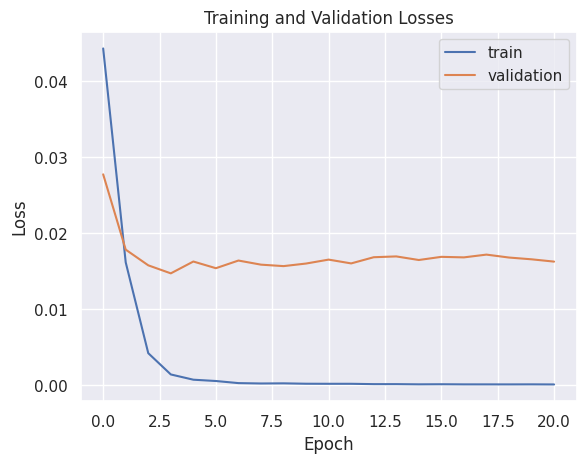

In [ ]:
# Plot the train and validation losses
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

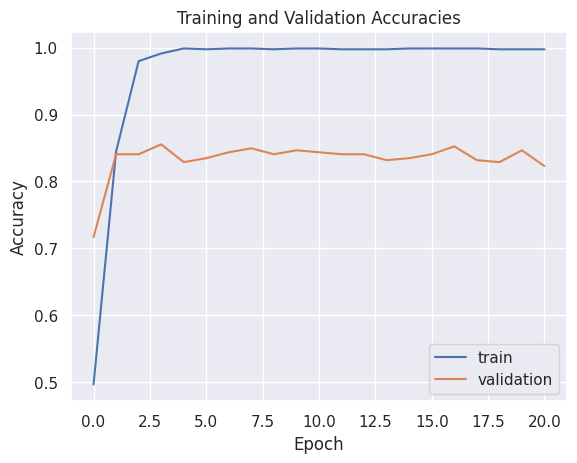

In [ ]:
# Plot the train and validation accuracies
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
all_preds = []
all_labels = []
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []
get_prediction2(model, valid_loader, device)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


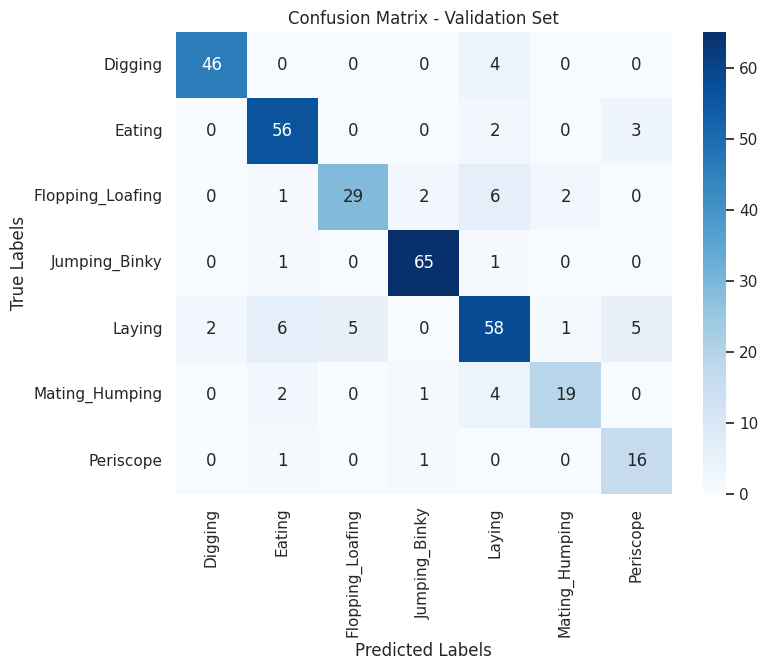

In [ ]:
# Plot the confusion matrix using seaborn
cm = confusion_matrix(all_labels, all_preds)
sns.set()
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".0f", xticklabels=dataset_classes, yticklabels=dataset_classes)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
print(classification_report(all_labels, all_preds, target_names=dataset_classes))

                  precision    recall  f1-score   support

         Digging       0.96      0.92      0.94        50
          Eating       0.84      0.92      0.88        61
Flopping_Loafing       0.85      0.72      0.78        40
   Jumping_Binky       0.94      0.97      0.96        67
          Laying       0.77      0.75      0.76        77
  Mating_Humping       0.86      0.73      0.79        26
       Periscope       0.67      0.89      0.76        18

        accuracy                           0.85       339
       macro avg       0.84      0.84      0.84       339
    weighted avg       0.86      0.85      0.85       339

